# Introduction

This is what I use to scrape reddit comments from r/gunners for analysis. 

# Loading packages

In [ ]:
!pip install praw
!pip install wordcloud
!pip install nltk

In [ ]:
# general
import pandas as pd
import numpy as np

# scraping
import praw

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter 
from nltk.corpus import stopwords
nltk.download('vader_lexicon')

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# Scraping comments 
 
Done using PRAW. In-depth documentation [here](https://praw.readthedocs.io/en/stable/tutorials/comments.html#extracting-comments).

Providing authentication to use PRAW. You can scrape comments with just read-only access, so there is no need to provide account credentials (username & password).

In [ ]:
reddit = praw.Reddit(
    client_id='YOURCLIENTID',
    client_secret='YOURCLIENTSECRET',
    password='YOURPASSWORD',
    username='YOURUSERNAME',
    user_agent='YOURUSERAGENT',
    check_for_async=False
)

print(reddit.read_only)

True


Creating a subreddit instance.

In [ ]:
subreddit = reddit.subreddit('gunners')

print(subreddit.display_name)
print(subreddit.title)
print(subreddit.description)

Creating a submission instance.

In [ ]:
submission = reddit.submission('11t4kdp')

In [ ]:
submission.comments.list()[1].__dict__

A function to scrape all comments and corresponding score, given a post url. 

In [ ]:
def getComments(url):
  # create submission object
  submission = reddit.submission(url)
  #create empty list
  comments_list = []
  # loop through comments and append each to list
  submission.comments.replace_more(limit=None)
  for comment in submission.comments.list():
      comments_list.append([#comment.total_awards_received,
                            comment.score,
                            #comment.controversiality,
                            #comment.author,
                            comment.body])
  # convert list to dataframe
  df = pd.DataFrame(comments_list)
  # rename columns
  df.columns = ['score','content']
  #df.columns = ['numawards','score','controversiality','author','content']
  return df

In [ ]:
#sporting = getComments('11t4kdp')
#palace = getComments('11vmdtz')
leeds = getComments('128n5re')

### Sentiment Analysis

NLTK has a built-in module for sentiment analysis called VADER. Documentation can be found [here](https://www.nltk.org/_modules/nltk/sentiment/vader.html).

Create a dataframe of all comments under [this post](https://www.reddit.com/r/Gunners/comments/11yfpe8/mesut_ozil_has_announced_his_retirement_from/) on Mesut Ozil's retirement from professional football.

In [ ]:
ozil = getComments('11yfpe8')

In [ ]:
# create vader object
sia= SentimentIntensityAnalyzer()

# apply VADER and store scores in column
ozil['VADER'] = ozil['content'].apply(lambda body: sia.polarity_scores(str(body)))

# put scores in individual columns
ozil['pos'] = ozil['VADER'].apply(lambda pos_dict:pos_dict['pos'])
ozil['neu'] = ozil['VADER'].apply(lambda neg_dict:neg_dict['neu'])
ozil['neg'] = ozil['VADER'].apply(lambda neg_dict:neg_dict['neg'])
ozil['compound'] = ozil['VADER'].apply(lambda score_dict:score_dict['compound'])

# create column of labelled sentiment based on compound score
ozil['sentiment']=''
ozil.loc[ozil.compound>0,'sentiment']='POSITIVE'
ozil.loc[ozil.compound==0,'sentiment']='NEUTRAL'
ozil.loc[ozil.compound<0,'sentiment']='NEGATIVE'

# print out how many comments per each labelled sentiment
len=ozil.shape
(rows,cols)=len
pos=0
neg=0
neutral=0
for i in range(0,rows):
  if ozil.loc[i]['sentiment']=='POSITIVE':
      pos=pos+1
  if ozil.loc[i]['sentiment']=='NEGATIVE':
      neg=neg+1
  if ozil.loc[i]['sentiment']=='NEUTRAL':
      neutral=neutral+1

print('Positive :'+str(pos) + '  Negative :' + str(neg) + '   Neutral :'+ str(neutral))

Some words seem to be scored incorrectly. I found that VADER evaluates the word 'clown' as positive, even though it is often used in a negative sense. The code below tells VADER to score the word negatively. Need to rerun everything after updating lexicon.

In [ ]:
new_word = {'clown':-5} 
sia.lexicon.update(new_word)

### Finding common ideas

I want to find out what are some common opinions among commenters.

Getting a dataframe of common words in the comment section.

In [ ]:
column = leeds['content']

words = []
for sentence in column:
    sentence_words = sentence.lower().split()
    words.extend(sentence_words)

stop_words = set(STOPWORDS)
words = [word for word in words if word not in stop_words]

word_counts = Counter(words)

word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])
word_counts_df = word_counts_df.sort_values('count', ascending=False)

word_counts_df

Getting a word cloud of common words in the comment section. Notice that I set a seed so that the generated image is the same every time.

(-0.5, 1599.5, 899.5, -0.5)

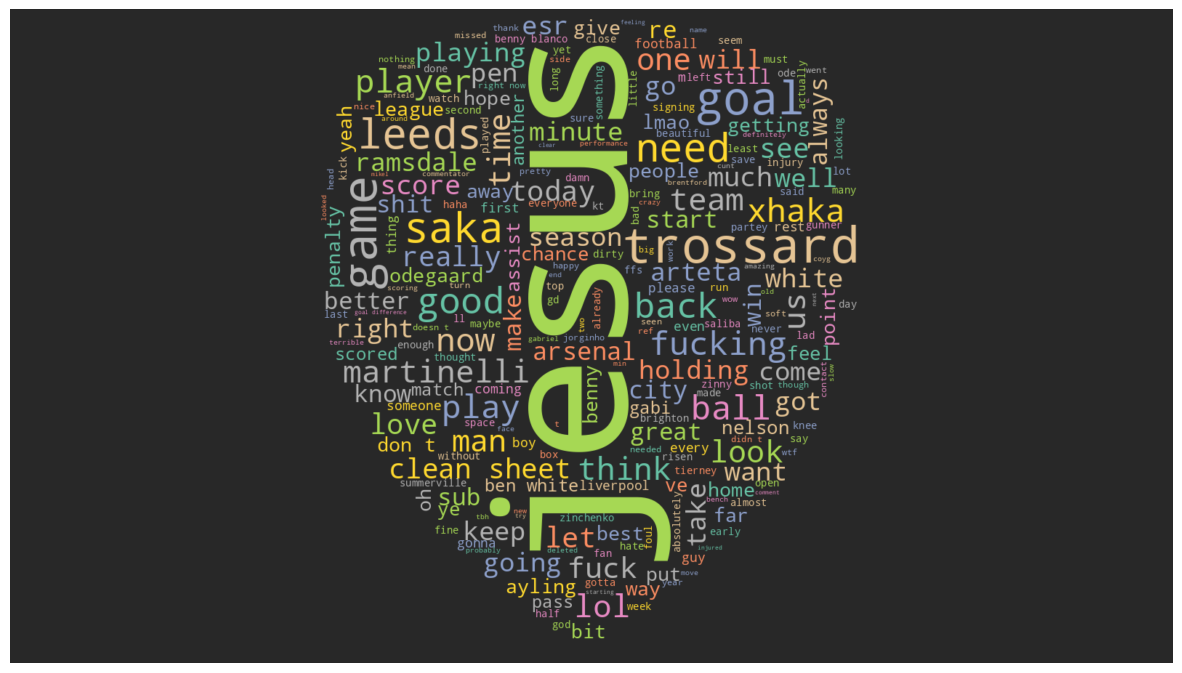

In [ ]:
mask = np.array(Image.open('/content/arsenal.png'))
stopwords = set(STOPWORDS)

# add additional words to ignore
stopwords.add('u')
stopwords.add('s')

# set up wordcloud object properties
wc = WordCloud(background_color='#282828',stopwords=stopwords,
               max_words=250,max_font_size=250,
               width=3000,height=3000,
               mask=mask,
               random_state=7)

# generate wordcloud object
word_string=' '.join(leeds['content']).lower()
wc.generate(word_string)

# display wordcloud object
plt.figure(figsize=(15,15))
plt.imshow(wc.recolor(colormap='Set2',random_state=17),interpolation='bilinear')
plt.axis('off')